In [1]:
import torch
import torch.nn as nn
import os
import mlp.data_providers as data_providers
import numpy as np
from storage_utils import load_statistics
from collections import OrderedDict
from model_architectures import ConvolutionalNetwork
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
val_data = data_providers.EMNISTDataProvider('valid', batch_size=1)
test_data = data_providers.EMNISTDataProvider('test', batch_size=1)

KeysView(<numpy.lib.npyio.NpzFile object at 0x10f154c18>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x1215ef208>)


In [3]:
model_names = ['2_layers', '3_layers', '4_layers', '5_layers']
models = OrderedDict()
stats = OrderedDict()

batch_size = 128
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_type = 'max_pooling'
num_filters = 64
possible_num_layers = [2,3,4,5]
num_epochs = 50
weight_decay_coefficient = 0
seed = 7112018
use_gpu = True

In [4]:
def rename_dict_key(old_dict):
    new_dict = OrderedDict()
    for key in old_dict.keys():
        new_dict[key[6:]] = old_dict[key]
    return new_dict

In [5]:
# load summary stats
for model_name, num_layers in zip(model_names, possible_num_layers):
    experiment_log_dir = './outputs/' + model_name + '/result_outputs/'
    summary = load_statistics(experiment_log_dir, 'summary.csv')
    stats[model_name] = summary

In [35]:
# training accuracy plot
plt.figure(figsize=(8,8), dpi=1000)
colors = ['r', 'g', 'b', 'm']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_acc = statistics['train_acc']
    valid_acc = statistics['val_acc']
    plt.plot(np.arange(1, len(train_acc)+1), np.array(train_acc, dtype='float') * 100, label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_acc)+1), np.array(valid_acc, dtype='float') * 100, label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=4, fontsize=14)
plt.ylim((60, 100))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.savefig('./plots/1_1_num_layers.pdf', dpi=1000)
# plt.title('Accuracy', fontsize=20)

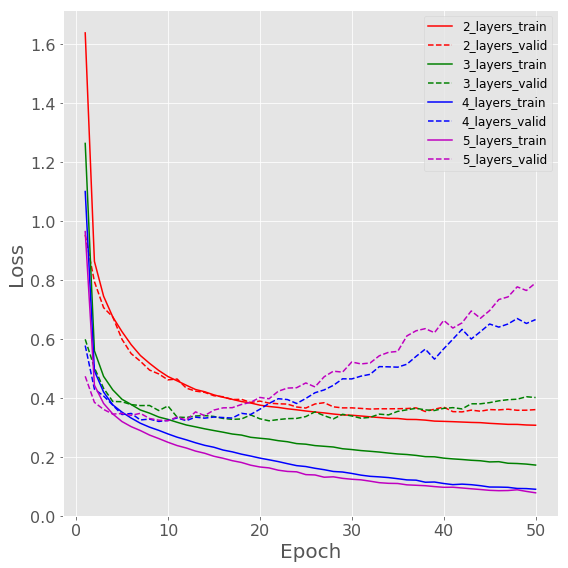

In [33]:
# training accuracy plot
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm']

for model_name, c in zip(model_names,  colors):
    statistics = stats[model_name]
    train_loss = statistics['train_loss']
    valid_loss = statistics['val_loss\n']
    plt.plot(np.arange(1, len(train_loss)+1), np.array(train_loss, dtype='float'), label=model_name+'_train', c=c)
    plt.plot(np.arange(1, len(valid_loss)+1), np.array(valid_loss, dtype='float'), label=model_name+'_valid', c=c, linestyle='--')
    
plt.legend(loc=0, fontsize=12)
# plt.ylim((50, 100))
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
# plt.title('Loss', fontsize=20)


In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

best_idxs = []
best_valid_accs = []
best_train_accs = []
num_params = []
# load best models
for model_name, num_layers in zip(model_names, possible_num_layers):
    conv_model = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type,
        num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=True)
    
    model_save_dir = './outputs/' + model_name + '/saved_models/'
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", 49))
    
    device = torch.device('cpu')
    state = torch.load(path, map_location=device)
    best_val_model_idx, best_val_model_acc = state['best_val_model_idx'], state['best_val_model_acc']
    best_idxs.append(best_val_model_idx)
    best_valid_accs.append(best_val_model_acc)
    
    best_train_acc = stats[model_name]['train_acc'][best_val_model_idx]
    best_train_accs.append(best_train_acc)
    
    path = os.path.join(model_save_dir, "{}_{}".format("train_model", best_val_model_idx))
    state = torch.load(path, map_location=device)
    new_state = rename_dict_key(state['network'])
    conv_model.load_state_dict(state_dict=new_state)
    conv_model.eval()
    models[model_name] = conv_model
    num = count_parameters(conv_model)
    num_params.append(num)

NameError: name 'model_names' is not defined

In [1]:
num_params

NameError: name 'num_params' is not defined

In [37]:
best_valid_accs

[0.8804623983739838, 0.8879573170731707, 0.885670731707317, 0.8880208333333334]

In [39]:
best_train_accs

['0.8873539532650448',
 '0.9015084827144686',
 '0.8903449103713188',
 '0.9079505441741357']

In [9]:
x, y = val_data.next()
x_test, y_test = torch.Tensor(x).float().to(device='cpu'), torch.Tensor(y).long().to(device='cpu')  # send data to device as torch tensors

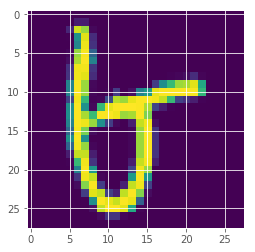

In [10]:
plt.imshow(x[0,0,...]*255)

In [11]:
def hook(module, inputdata, output):
    outputs.append(output)

In [19]:
feature_maps = OrderedDict()

for model_name in model_names:
    conv_model = models[model_name]
    outputs = []
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        h = conv_model.layer_dict[layer_name].register_forward_hook(hook)
        h_x = conv_model(x_test)
        h.remove()
        feature_maps[model_name + '_' + layer_name] = outputs[-1].detach().numpy()
    print(len(outputs))

2_layers_conv_0
2_layers_dim_reduction_max_pool_0
2_layers_conv_1
2_layers_dim_reduction_max_pool_1
4
3_layers_conv_0
3_layers_dim_reduction_max_pool_0
3_layers_conv_1
3_layers_dim_reduction_max_pool_1
3_layers_conv_2
3_layers_dim_reduction_max_pool_2
6
4_layers_conv_0
4_layers_dim_reduction_max_pool_0
4_layers_conv_1
4_layers_dim_reduction_max_pool_1
4_layers_conv_2
4_layers_dim_reduction_max_pool_2
4_layers_conv_3
4_layers_dim_reduction_max_pool_3
8
5_layers_conv_0
5_layers_dim_reduction_max_pool_0
5_layers_conv_1
5_layers_dim_reduction_max_pool_1
5_layers_conv_2
5_layers_dim_reduction_max_pool_2
5_layers_conv_3
5_layers_dim_reduction_max_pool_3
5_layers_conv_4
5_layers_dim_reduction_max_pool_4
10


In [30]:
def show_batch_feature_maps(outputs):
    grid_size = int(outputs.shape[0] ** 0.5)
    fig, ax = plt.subplots(grid_size, grid_size)
    ax = ax.flatten()
    
    for i in range(outputs.shape[0]):
        ax[i].imshow(outputs[i], cmap='Greys')
        ax[i].axis('off')
    plt.show()
    
    return fig, ax

2_layers_conv_0


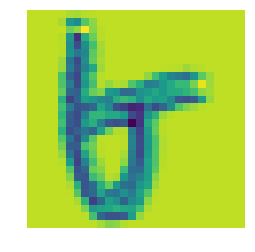

2_layers_dim_reduction_max_pool_0


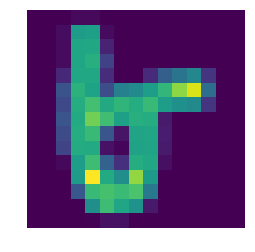

2_layers_conv_1


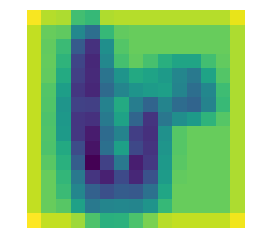

2_layers_dim_reduction_max_pool_1


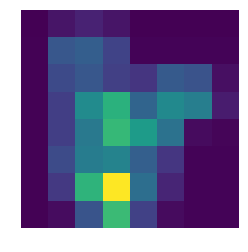

3_layers_conv_0


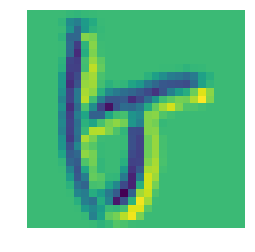

3_layers_dim_reduction_max_pool_0


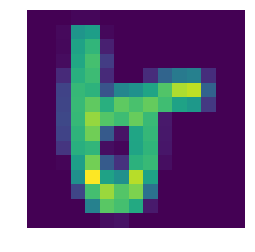

3_layers_conv_1


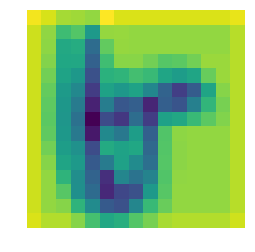

3_layers_dim_reduction_max_pool_1


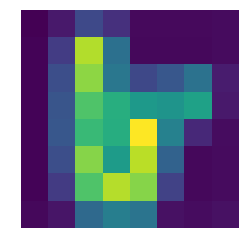

3_layers_conv_2


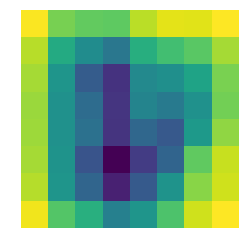

3_layers_dim_reduction_max_pool_2


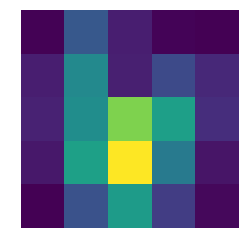

4_layers_conv_0


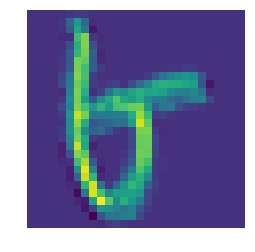

4_layers_dim_reduction_max_pool_0


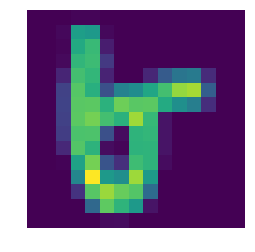

4_layers_conv_1


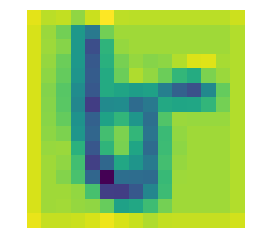

4_layers_dim_reduction_max_pool_1


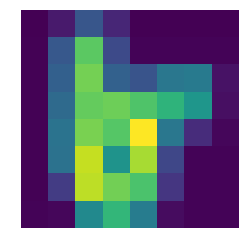

4_layers_conv_2


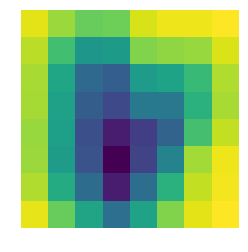

4_layers_dim_reduction_max_pool_2


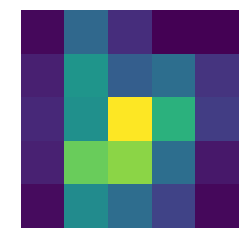

4_layers_conv_3


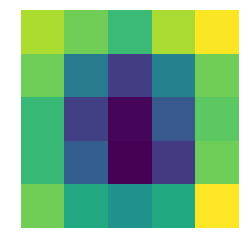

4_layers_dim_reduction_max_pool_3


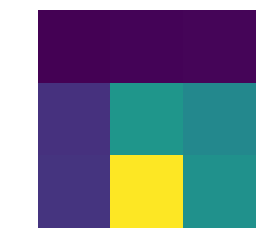

5_layers_conv_0


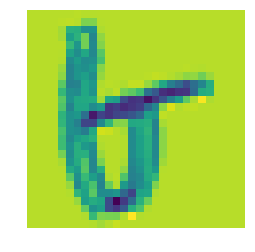

5_layers_dim_reduction_max_pool_0


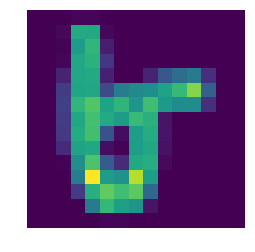

5_layers_conv_1


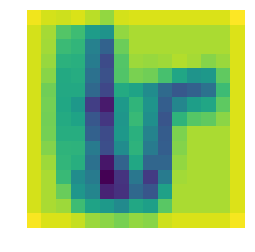

5_layers_dim_reduction_max_pool_1


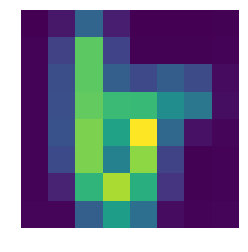

5_layers_conv_2


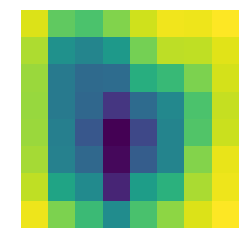

5_layers_dim_reduction_max_pool_2


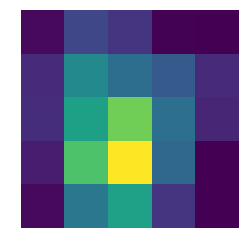

5_layers_conv_3


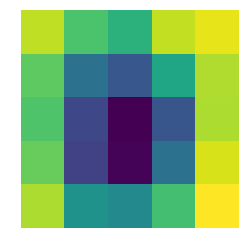

5_layers_dim_reduction_max_pool_3


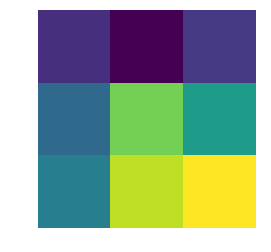

5_layers_conv_4


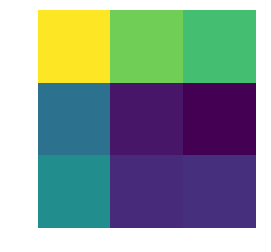

5_layers_dim_reduction_max_pool_4


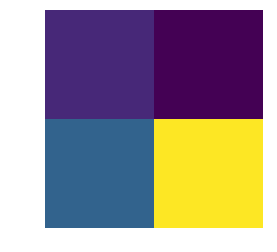

In [25]:
for model_name in model_names:
    conv_model = models[model_name]
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        outputs = feature_maps[model_name + '_' + layer_name][0]
        avg_output = np.mean(outputs, axis=0)
        plt.imshow(avg_output)
        plt.axis('off')
        plt.show()

2_layers_conv_0


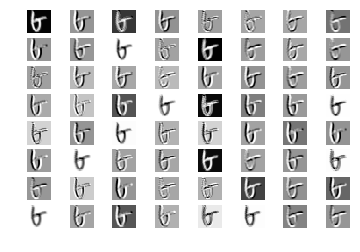

2_layers_dim_reduction_max_pool_0


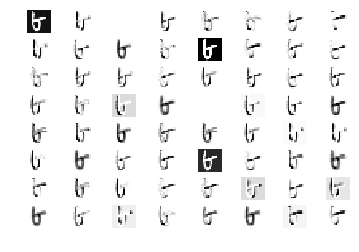

2_layers_conv_1


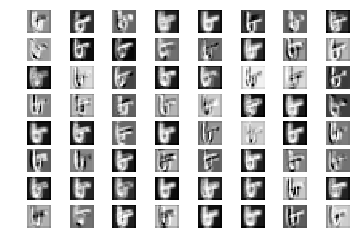

2_layers_dim_reduction_max_pool_1


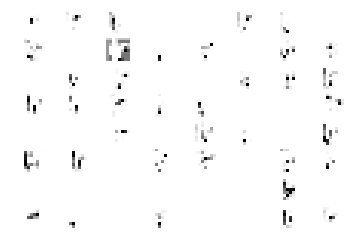

3_layers_conv_0


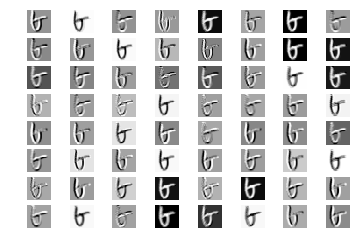

3_layers_dim_reduction_max_pool_0


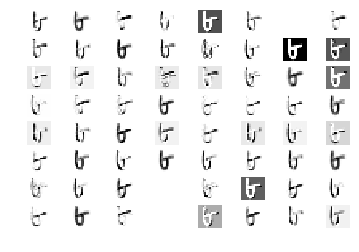

3_layers_conv_1


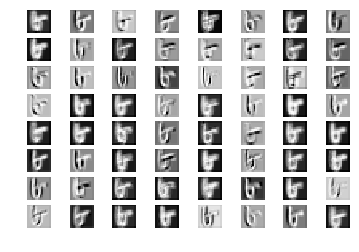

3_layers_dim_reduction_max_pool_1


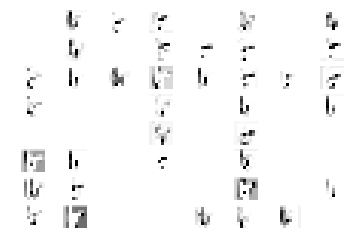

3_layers_conv_2


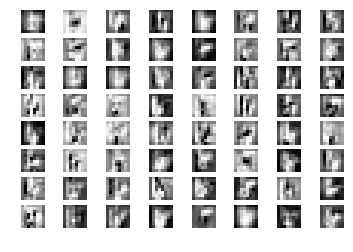

3_layers_dim_reduction_max_pool_2


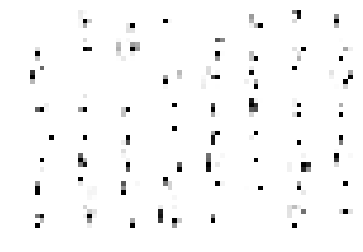

4_layers_conv_0


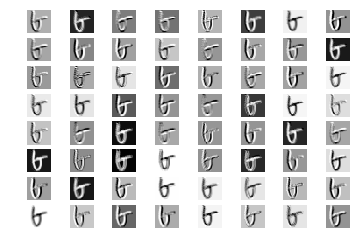

4_layers_dim_reduction_max_pool_0


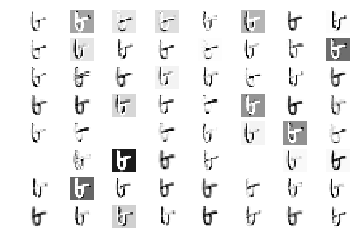

4_layers_conv_1


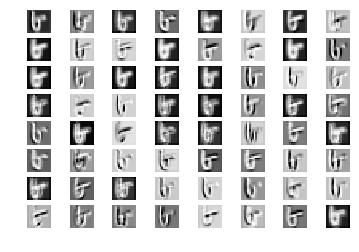

4_layers_dim_reduction_max_pool_1


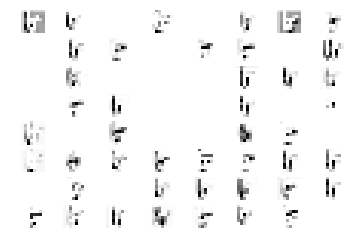

4_layers_conv_2


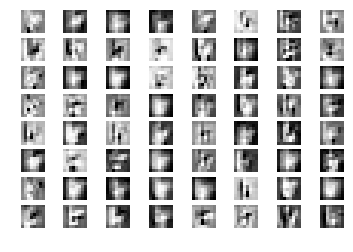

4_layers_dim_reduction_max_pool_2


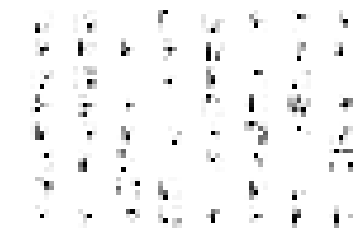

4_layers_conv_3


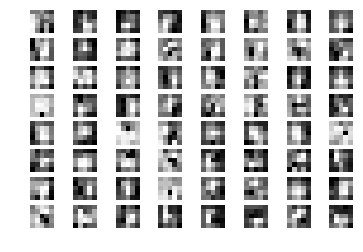

4_layers_dim_reduction_max_pool_3


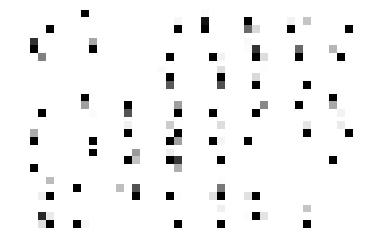

5_layers_conv_0


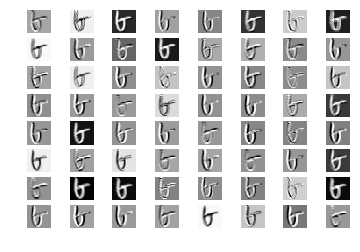

5_layers_dim_reduction_max_pool_0


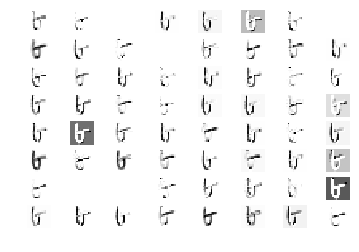

5_layers_conv_1


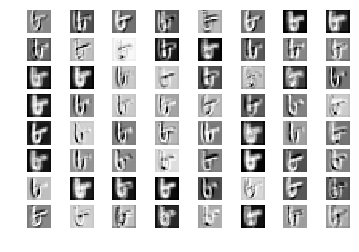

5_layers_dim_reduction_max_pool_1


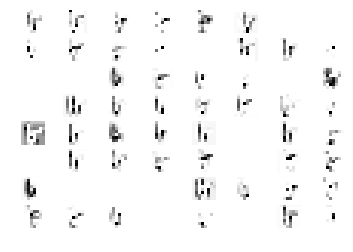

5_layers_conv_2


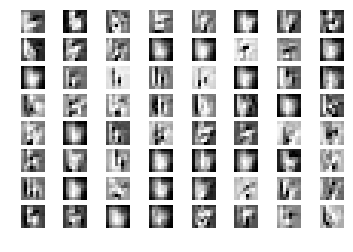

5_layers_dim_reduction_max_pool_2


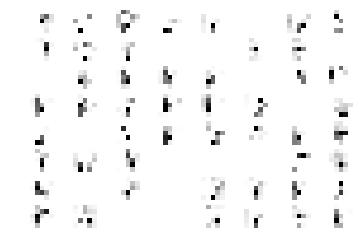

5_layers_conv_3


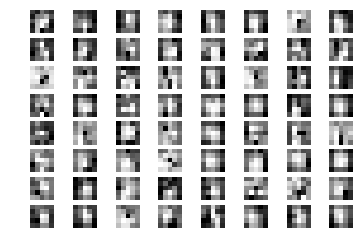

5_layers_dim_reduction_max_pool_3


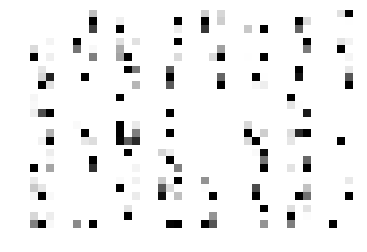

5_layers_conv_4


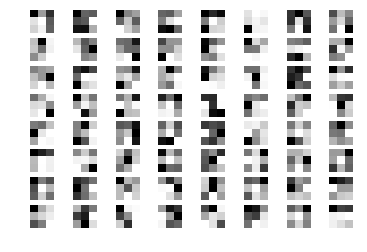

5_layers_dim_reduction_max_pool_4


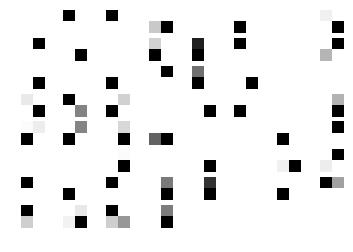

In [31]:
for model_name in model_names:
    conv_model = models[model_name]
    for layer_name in conv_model.layer_dict.keys():
        print(model_name + '_' + layer_name)
        outputs = feature_maps[model_name + '_' + layer_name][0]
        show_batch_feature_maps(outputs)

In [13]:
# hook test
h = conv_2.layer_dict.conv_1.register_forward_hook(
        lambda m, i, o: \
        print(
            'm:', type(m),
            '\ni:', type(i),
                '\n   len:', len(i),
                '\n   type:', type(i[0]),
                '\n   data size:', i[0].data.size(),
                '\n   data type:', i[0].data.type(),
            '\no:', type(o),
                '\n   data size:', o.data.size(),
                '\n   data type:', o.data.type(),
        )
)

h_x = conv_2(x_test)
h.remove()

NameError: name 'conv_2' is not defined